# ACCESS Data Retrieval and Streamfunction Calculation

This notebook retrieves data from raw ACCESS-OM-01 output and converts them into useful input data for training ML models in the `models.ipynb` notebook. The streamfunction and MOC strength are also calculated using the definition laid out in Solodoch *et al.* (2023), and saved for use as a target variable in ML models.

This notebook is required to reproduce any results from Section **blah** in our final report.

In [4]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import scipy.optimize as op

Downloading all data from the ACCESS files and merging into a single dataset. This cell assumes that ACCESS data is available in a folder called `data/` in the current working directory, with the shortnames given in the list below.

In [5]:
shortnames = ['sea_level_SO_monthly', 'surface_pot_temp', 'surface_salt', 'temp_yflux_adv_30S', 'temp_yflux_adv_60S', 'u_zonalSlices', 'v_zonalSlices', 'pbot_t']

access_data = xr.merge([xr.open_dataset(f"data/{shortname}.nc") for shortname in shortnames], compat='override')

access_data

<xarray.Dataset>
Dimensions:           (xt_ocean: 3600, yt_ocean: 930, time: 349, yu_ocean: 2,
                       st_ocean: 75, xu_ocean: 3600)
Coordinates:
  * xt_ocean          (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean          (yt_ocean) float64 -81.11 -81.07 -81.02 ... -30.15 -30.07
  * time              (time) datetime64[ns] 1989-12-16T12:00:00 ... 2018-12-1...
  * yu_ocean          (yu_ocean) float64 -30.02 -60.02
  * st_ocean          (st_ocean) float64 0.5413 1.681 ... 5.511e+03 5.709e+03
  * xu_ocean          (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
Data variables:
    sea_level         (time, yt_ocean, xt_ocean) float32 ...
    surface_pot_temp  (time, yt_ocean, xt_ocean) float32 ...
    surface_salt      (time, yt_ocean, xt_ocean) float32 ...
    temp_yflux_adv    (time, st_ocean, xt_ocean) float32 ...
    u                 (time, st_ocean, yu_ocean, xu_ocean) float32 ...
    v                 (time, st_ocean, yu_ocean, xu_ocean) float32 ...
    pbot_t            (time, yt_ocean, xt_ocean) float32 ...

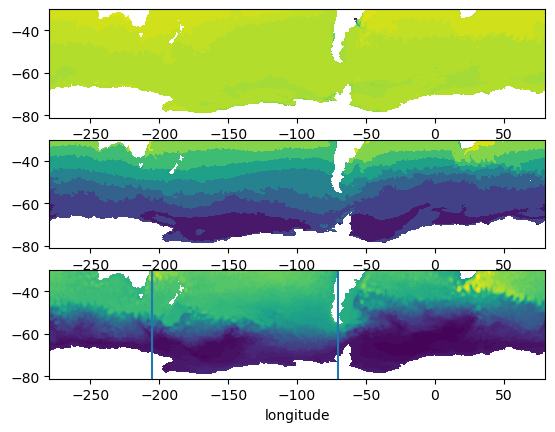

In [6]:
fig, axs = plt.subplots(3, 1)

axs[0].contourf(access_data.xt_ocean, access_data.yt_ocean, access_data.surface_salt[0,:,:], 60)
axs[1].contourf(access_data.xt_ocean, access_data.yt_ocean, access_data.surface_pot_temp[0,:,:])
axs[2].contourf(access_data.xt_ocean, access_data.yt_ocean, access_data.sea_level[0,:,:], 60)
axs[2].set_xlabel('longitude')
# axs[2].gridlines()
axs[2].axvline(-205)
axs[2].axvline(-70)
plt.show()

# Selecting only the data located at 60S

In [7]:
access_data_60S_so = access_data.sel(yt_ocean = -60, yu_ocean = -60, method='nearest')

access_data_60S_so

<xarray.Dataset>
Dimensions:           (xt_ocean: 3600, time: 349, st_ocean: 75, xu_ocean: 3600)
Coordinates:
  * xt_ocean          (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
    yt_ocean          float64 -60.0
  * time              (time) datetime64[ns] 1989-12-16T12:00:00 ... 2018-12-1...
    yu_ocean          float64 -60.02
  * st_ocean          (st_ocean) float64 0.5413 1.681 ... 5.511e+03 5.709e+03
  * xu_ocean          (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
Data variables:
    sea_level         (time, xt_ocean) float32 ...
    surface_pot_temp  (time, xt_ocean) float32 ...
    surface_salt      (time, xt_ocean) float32 ...
    temp_yflux_adv    (time, st_ocean, xt_ocean) float32 ...
    u                 (time, st_ocean, xu_ocean) float32 ...
    v                 (time, st_ocean, xu_ocean) float32 ...
    pbot_t            (time, xt_ocean) float32 ...

Spatially display variables used as covariates in models

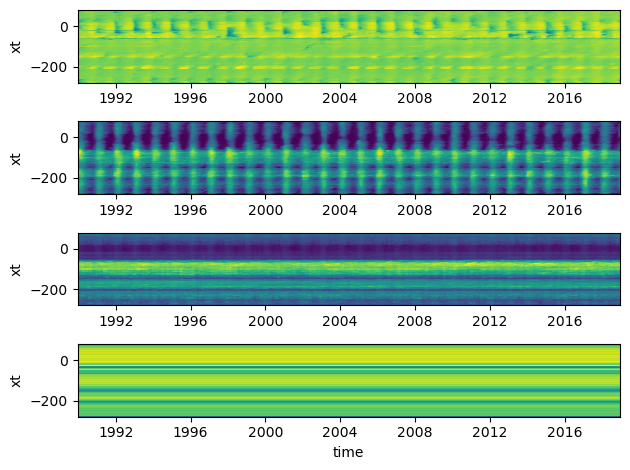

In [41]:
fig, axs = plt.subplots(4, 1)

axs[0].contourf(access_data_60S_so.time, access_data_60S_so.xt_ocean, access_data_60S_so.surface_salt.T, 60)
axs[0].set_ylabel('xt')
axs[1].contourf(access_data_60S_so.time, access_data_60S_so.xt_ocean, access_data_60S_so.surface_pot_temp.T, 60)
axs[1].set_ylabel('xt')
axs[2].contourf(access_data_60S_so.time, access_data_60S_so.xt_ocean, access_data_60S_so.sea_level.T, 60)
axs[2].set_ylabel('xt')
axs[3].contourf(access_data_60S_so.time, access_data_60S_so.xt_ocean, access_data_60S_so.pbot_t.T, 60)
axs[3].set_ylabel('xt')
axs[3].set_xlabel('time')
fig.tight_layout()
plt.show()

Calculate the streamfunction from a given velocity field at a given latitude and basin

In [10]:
import scipy.integrate as integrate
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def sigma_2_to_depth(sigma_2):
    # calculate the depth of a given potential density surface, ACCESS data for temperature and salinity at depth has not been provided therefore no calculation can be made
    return sigma_2

def calc_x_bounds(y, basin):
    # calculate the x bounds of a given basin at a given latitude - hardcoded for the latitudes we're interested in.
    if y == -60:
        return (-280, 80)
    elif y == -30 and basin == 'atlantic':
        return (-50, 15)
    elif y == -30 and basin == 'pacific':
        return (-205, -70)
    else:
        return

def streamfunction(data, y=-60., basin='southern'):
    """Calculate the streamfunction of a given velocity field at a given latitude and basin.

    Args:
        data (xarray.DataArray): DataArray containing the variable `v` (velocity), on a grid with coordinates `st_ocean`, `xu_ocean`, `yu_ocean` and `time`.
        y (float, optional): Latitude at which to calculate streamfunction. Defaults to -60.
        basin (str, optional): Basin name, one of `"southern", "atlantic" or "pacific"`. Defaults to 'southern'.

    Returns:
        xarray.Dataset: Dataset containing the variable `streamfunction` (streamfunction), on a grid with coordinates `st_ocean` and `time`.
    """
    # set sigma_2 as a coordinate
    data = data.assign_coords(sigma_2=data.st_ocean)

    # calculate grid cell areas
    rad_at_lat_y = 6371000 * np.cos(np.deg2rad(y)) # convert from degrees to meters
    data['xm'] = rad_at_lat_y * np.deg2rad(data.xu_ocean)
    data['dxu'] = data.xu_ocean.diff('xu_ocean') # grid cell width in longitude
    data['dxm'] = rad_at_lat_y * np.deg2rad(data.dxu) # grid cell width in meters
    data['dst'] = data.st_ocean.diff('st_ocean') # grid cell width in depth

    data = data.reset_coords(['dxm', 'dst']) # make these data variables instead of coordinates bcus it makes more sense

    data['streamfunction'] = xr.DataArray(np.zeros((len(data.sigma_2), len(data.time))), coords=[data.st_ocean, data.time])
    data['streamfunction_simpson'] = xr.DataArray(np.zeros((len(data.sigma_2), len(data.time))), coords=[data.st_ocean, data.time])

    x_bounds = calc_x_bounds(y, basin)
    data = data.sel(yu_ocean = y, method='nearest')
    for i, sigma_2 in enumerate(data.st_ocean):
        # here we assume that sigma_2 is a depth, whereas it's supposed to be a potential density
        min_depth = sigma_2_to_depth(sigma_2)

        # sum across all longitudes, weighted by the grid cell width
        data['v_weighted_by_dxm'] = data.v * data.dxm
        data['v_weighted_by_dxm_summed_over_x'] = data.v_weighted_by_dxm.sel(xu_ocean=slice(*x_bounds)).sum('xu_ocean')
        data['v_weighted_by_dxm_summed_over_x_simpson'] = (('time', 'st_ocean'), integrate.simpson(data.v.to_numpy(), data.xm.to_numpy()))

        # sum across all depths up to min_depth, weighted by grid cell depth
        data['v_weighted_by_dxm_summed_over_x_weighted_by_dst'] = data.v_weighted_by_dxm_summed_over_x * data.dst
        data['v_weighted_by_dxm_summed_over_x_weighted_by_dst_summed_over_z'] = data.v_weighted_by_dxm_summed_over_x_weighted_by_dst.sel(st_ocean=slice(min_depth, data.st_ocean[-1])).sum('st_ocean')
        data['v_weighted_by_dxm_summed_over_x_weighted_by_dst_summed_over_z_simpson'] = (('time'), integrate.simpson(data.v_weighted_by_dxm_summed_over_x_simpson.to_numpy(), data.st_ocean.to_numpy()))
        
        # calculate the streamfunction
        data['streamfunction'][i,:] = -data.v_weighted_by_dxm_summed_over_x_weighted_by_dst_summed_over_z
        data['streamfunction_simpson'][i,:] = -data.v_weighted_by_dxm_summed_over_x_weighted_by_dst_summed_over_z_simpson

    return data


access_data_v = access_data.v

In [11]:
Psi_60S_so = streamfunction(access_data_v)

In [12]:
Psi_30S_at = streamfunction(access_data_v, y=-30, basin='atlantic')

In [13]:
Psi_30S_pac = streamfunction(access_data_v, y=-30, basin='pacific')

In [14]:
Psi_60S_so

<xarray.Dataset>
Dimensions:                                                                (
                                                                            time: 349,
                                                                            st_ocean: 75,
                                                                            xu_ocean: 3600)
Coordinates:
  * time                                                                   (time) datetime64[ns] ...
    yu_ocean                                                               float64 ...
  * st_ocean                                                               (st_ocean) float64 ...
  * xu_ocean                                                               (xu_ocean) float64 ...
    sigma_2                                                                (st_ocean) float64 ...
    xm                                                                     (xu_ocean) float64 ...
    dxu                                                                    (xu_ocean) float64 ...
Data variables:
    dxm                                                                    (xu_ocean) float64 ...
    dst                                                                    (st_ocean) float64 ...
    v                                                                      (time, st_ocean, xu_ocean) float32 ...
    streamfunction                                                         (st_ocean, time) float64 ...
    streamfunction_simpson                                                 (st_ocean, time) float64 ...
    v_weighted_by_dxm                                                      (time, st_ocean, xu_ocean) float64 ...
    v_weighted_by_dxm_summed_over_x                                        (time, st_ocean) float64 ...
    v_weighted_by_dxm_summed_over_x_simpson                                (time, st_ocean) float64 ...
    v_weighted_by_dxm_summed_over_x_weighted_by_dst                        (time, st_ocean) float64 ...
    v_weighted_by_dxm_summed_over_x_weighted_by_dst_summed_over_z          (time) float64 ...
    v_weighted_by_dxm_summed_over_x_weighted_by_dst_summed_over_z_simpson  (time) float64 ...

Display the calculated streamfunctions in both depth-time space, and as a time-average in depth space. Time-averaged velocity fields are also displayed for clarity.

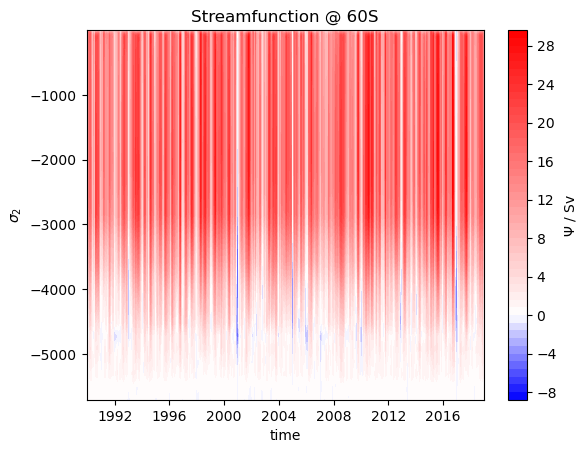

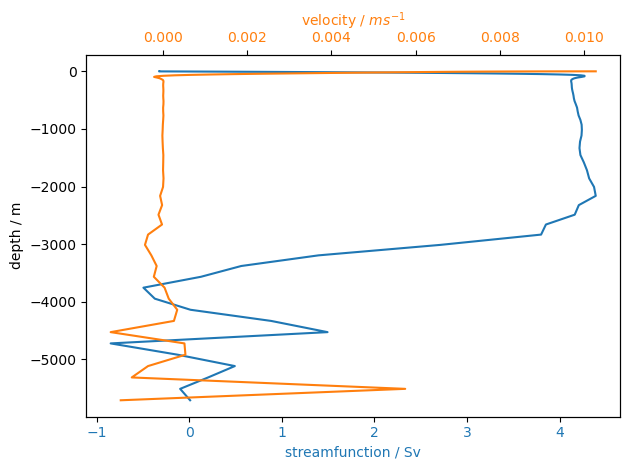

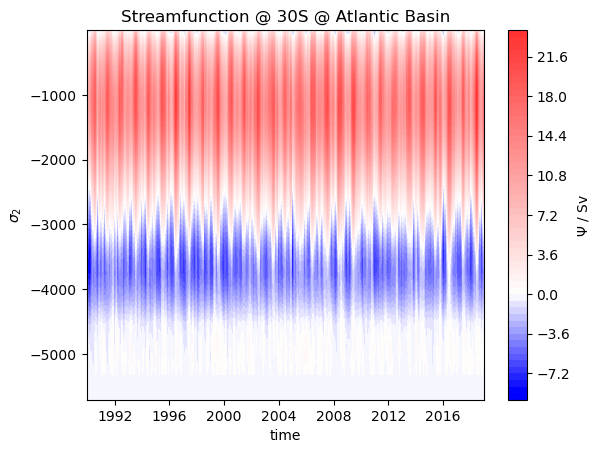

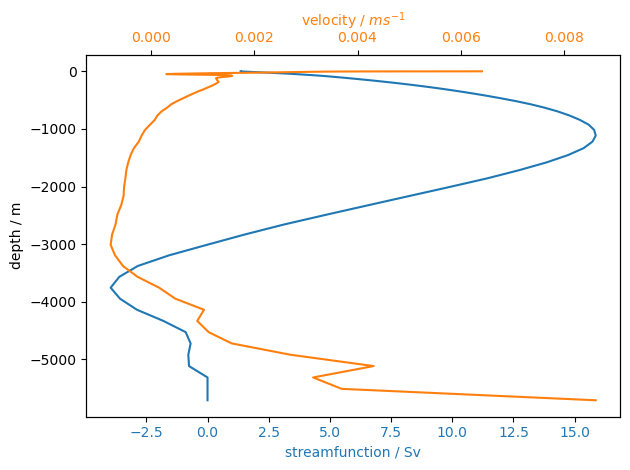

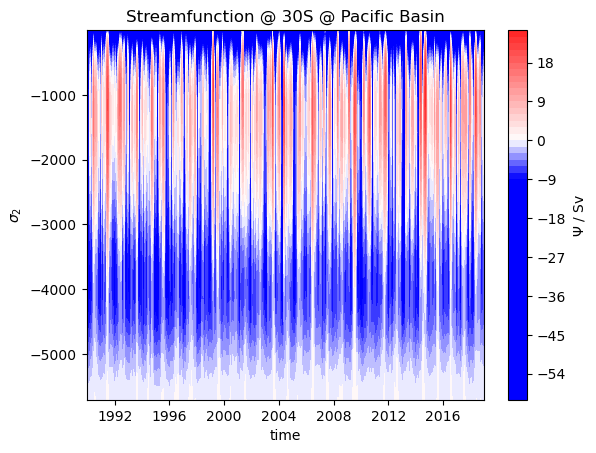

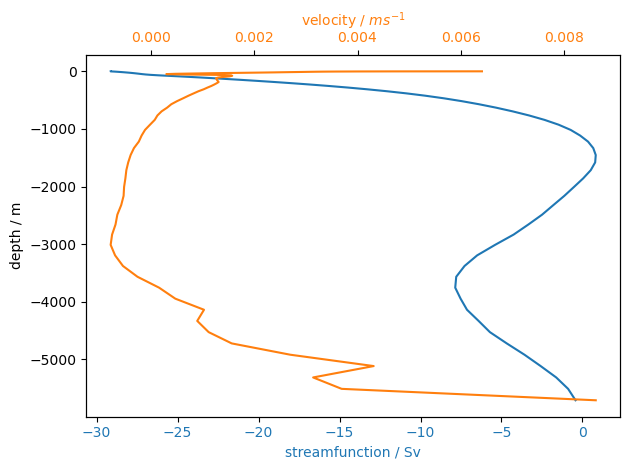

In [39]:
from matplotlib import colors
norm=colors.TwoSlopeNorm(vcenter=0.)

'''
60S Southern Basin
'''
plt.contourf(Psi_60S_so.time, -Psi_60S_so.st_ocean[::], Psi_60S_so.streamfunction*1e-6, 60, cmap='bwr', norm=norm)
plt.colorbar(label=r'$\Psi$ / Sv')
plt.xlabel('time')
plt.ylabel(r'$\sigma_2$')
plt.title('Streamfunction @ 60S')
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('depth / m')
ax1.set_xlabel('streamfunction / Sv', color=color)
ax1.plot(Psi_60S_so.streamfunction[:,5]*1e-6, -Psi_60S_so.st_ocean[::], color=color)
ax1.tick_params(axis='x', labelcolor=color)

ax2 = ax1.twiny()

color = 'tab:orange'
ax2.set_xlabel(r'velocity / $ms^{-1}$', color=color)
ax2.plot(Psi_60S_so.v.mean(dim=['xu_ocean'])[5,:], -Psi_60S_so.st_ocean[::], color=color)
ax2.tick_params(axis='x', labelcolor=color)

fig.tight_layout()
plt.show()

'''
30S Atlantic Basin
'''
plt.contourf(Psi_30S_at.time, -Psi_30S_at.st_ocean[::], Psi_30S_at.streamfunction*1e-6, 60, cmap='bwr', norm=norm)
plt.colorbar(label=r'$\Psi$ / Sv')
plt.xlabel('time')
plt.ylabel(r'$\sigma_2$')
plt.title('Streamfunction @ 30S @ Atlantic Basin')
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('depth / m')
ax1.set_xlabel('streamfunction / Sv', color=color)
ax1.plot(Psi_30S_at.streamfunction[:,5]*1e-6, -Psi_30S_at.st_ocean[::], color=color)
ax1.tick_params(axis='x', labelcolor=color)

ax2 = ax1.twiny()

color = 'tab:orange'
ax2.set_xlabel(r'velocity / $ms^{-1}$', color=color)
ax2.plot(Psi_30S_at.v.mean(dim=['xu_ocean'])[5,:], -Psi_30S_at.st_ocean[::], color=color)
ax2.tick_params(axis='x', labelcolor=color)

fig.tight_layout() 
plt.show()

'''
30S Pacific Basin
'''
plt.contourf(Psi_30S_pac.time, -Psi_30S_pac.st_ocean[::], Psi_30S_pac.streamfunction*1e-6, 60, cmap='bwr', norm=norm)
plt.colorbar(label=r'$\Psi$ / Sv')
plt.xlabel('time')
plt.ylabel(r'$\sigma_2$')
plt.title('Streamfunction @ 30S @ Pacific Basin')
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('depth / m')
ax1.set_xlabel('streamfunction / Sv', color=color)
ax1.plot(Psi_30S_pac.streamfunction[:,5]*1e-6, -Psi_30S_pac.st_ocean[::], color=color)
ax1.tick_params(axis='x', labelcolor=color)

ax2 = ax1.twiny()

color = 'tab:orange'
ax2.set_xlabel(r'velocity / $ms^{-1}$', color=color)
ax2.plot(Psi_30S_pac.v.mean(dim=['xu_ocean'])[5,:], -Psi_30S_pac.st_ocean[::], color=color)
ax2.tick_params(axis='x', labelcolor=color)

fig.tight_layout()
plt.show()

Find $\sigma_2^0$ - the "depth" at which the time-averaged absolute value of the streamfunction is maximised (using first Solodoch method). As noted in the code, temperature and salinity data at depth was unavailable for this project, so $\sigma_2^0$ is used as a depth coordinate throught this work. This is a notable limitation of this analysis.

<xarray.DataArray 'sigma_2' ()>
array(2006.97521973)
Coordinates:
    yu_ocean  float64 -60.02
    st_ocean  float64 2.007e+03
    sigma_2   float64 2.007e+03
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean


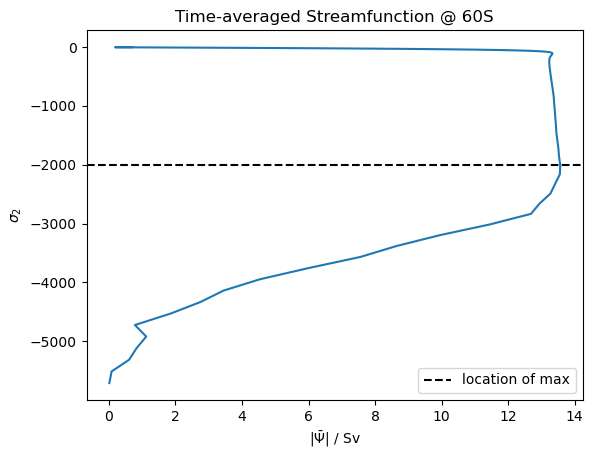

<xarray.DataArray 'sigma_2' ()>
array(3755.27416992)
Coordinates:
    yu_ocean  float64 -30.02
    st_ocean  float64 3.755e+03
    sigma_2   float64 3.755e+03
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean


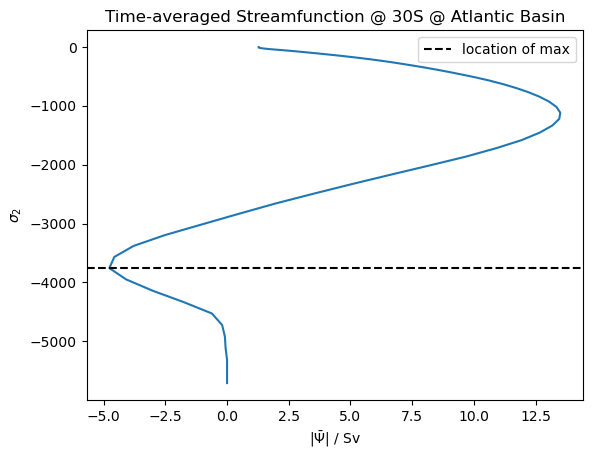

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<xarray.DataArray 'sigma_2' ()>
array(3946.16601562)
Coordinates:
    yu_ocean  float64 -30.02
    st_ocean  float64 3.946e+03
    sigma_2   float64 3.946e+03
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean


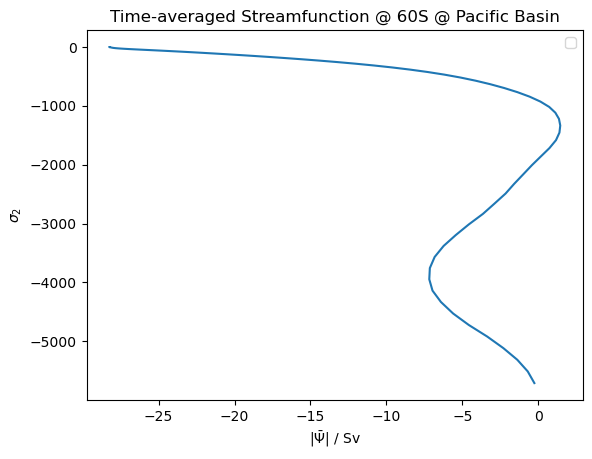

In [22]:
'''
Streamfunction @ 60S
'''
abs_t_avg_Psi_60S_so = abs(Psi_60S_so.streamfunction.mean(axis=1))
sigma_2_0_60S_so = abs_t_avg_Psi_60S_so.where(abs_t_avg_Psi_60S_so==abs_t_avg_Psi_60S_so.max(), drop=True).squeeze().sigma_2 # some code I found online to find the location of a maximum value in an xarray
print(sigma_2_0_60S_so)

plt.plot(abs_t_avg_Psi_60S_so*1e-6, -Psi_60S_so.st_ocean)
plt.axhline(-sigma_2_0_60S_so, color='black', linestyle='--', label='location of max')
plt.legend()
plt.ylabel(r'$\sigma_2$')
plt.xlabel(r'$|\bar{\Psi}|$ / Sv')
plt.title('Time-averaged Streamfunction @ 60S')
plt.show()

'''
Streamfunction @ 30S @ Atlantic
'''
t_avg_Psi_30S_at = Psi_30S_at.streamfunction.mean(axis=1)
sigma_2_0_30S_at = t_avg_Psi_30S_at.where(t_avg_Psi_30S_at==t_avg_Psi_30S_at.min(), drop=True).squeeze().sigma_2 # some code I found online to find the location of a maximum value in an xarray
print(sigma_2_0_30S_at)

plt.plot(t_avg_Psi_30S_at*1e-6, -Psi_30S_at.st_ocean)
plt.axhline(-sigma_2_0_30S_at, color='black', linestyle='--', label='location of max')
plt.legend()
plt.ylabel(r'$\sigma_2$')
plt.xlabel(r'$|\bar{\Psi}|$ / Sv')
plt.title('Time-averaged Streamfunction @ 30S @ Atlantic Basin')
plt.show()

'''
Streamfunction @ 30S @ Pacific
'''
t_avg_Psi_30S_pac = Psi_30S_pac.streamfunction.mean(axis=1)
# t_avg_Psi_30S_pac = t_avg_Psi_30S_pac.sel(st_ocean=slice(3000, 5000))
sigma_2_0_30S_pac = t_avg_Psi_30S_pac.where(t_avg_Psi_30S_pac==t_avg_Psi_30S_pac.sel(st_ocean=slice(3000, 5000)).min(), drop=True).squeeze().sigma_2 # some code I found online to find the location of a maximum value in an xarray
print(sigma_2_0_30S_pac)

plt.plot(t_avg_Psi_30S_pac*1e-6, -Psi_30S_pac.st_ocean)
# plt.axhline(-sigma_2_0_30S_pac, color='black', linestyle='--', label='location of max')
plt.legend()
plt.ylabel(r'$\sigma_2$')
plt.xlabel(r'$|\bar{\Psi}|$ / Sv')
plt.title('Time-averaged Streamfunction @ 60S @ Pacific Basin')
plt.show()



Create final MOC strength array for use in modelling

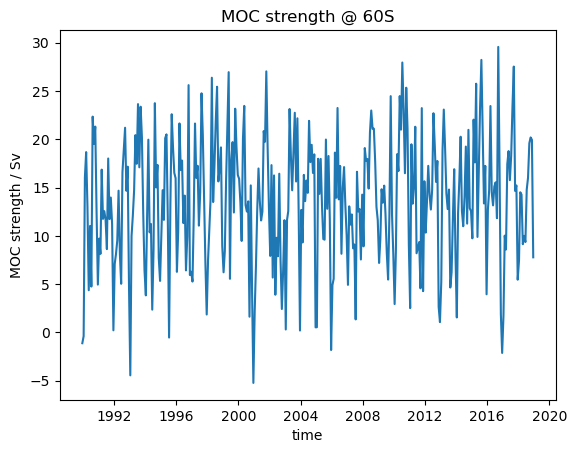

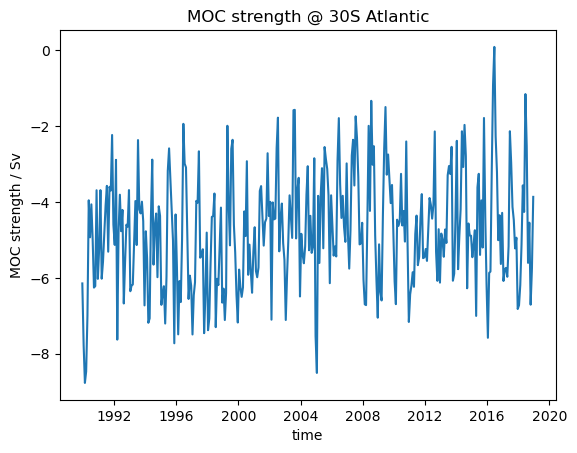

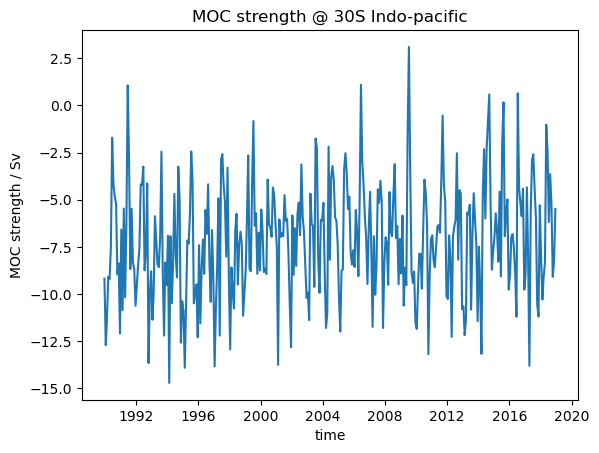

In [23]:
MOC_60S_so = Psi_60S_so.streamfunction.sel(st_ocean=sigma_2_0_60S_so, method='nearest').to_dataset(name='MOC')
plt.plot(Psi_60S_so.time, MOC_60S_so.MOC*1e-6)
plt.xlabel('time')
plt.ylabel(r'MOC strength / Sv')
plt.title('MOC strength @ 60S')
plt.show()


MOC_30S_at = Psi_30S_at.streamfunction.sel(st_ocean=sigma_2_0_30S_at, method='nearest').to_dataset(name='MOC')
plt.plot(Psi_30S_at.time, MOC_30S_at.MOC*1e-6)
plt.xlabel('time')
plt.ylabel(r'MOC strength / Sv')
plt.title('MOC strength @ 30S Atlantic')
plt.show()


MOC_30S_pac = Psi_30S_pac.streamfunction.sel(st_ocean=sigma_2_0_30S_pac, method='nearest').to_dataset(name='MOC')
plt.plot(Psi_30S_pac.time, MOC_30S_pac.MOC*1e-6)
plt.xlabel('time')
plt.ylabel(r'MOC strength / Sv')
plt.title('MOC strength @ 30S Indo-pacific')
plt.show()

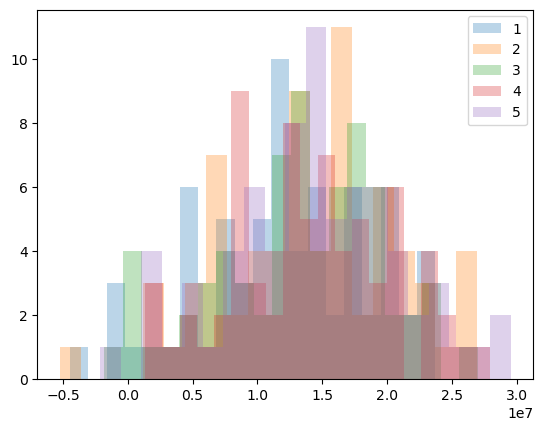

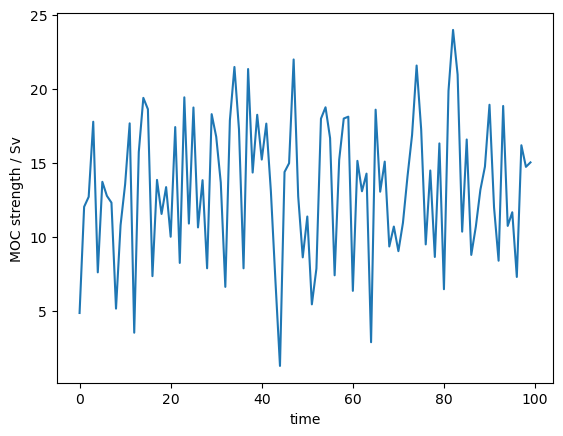

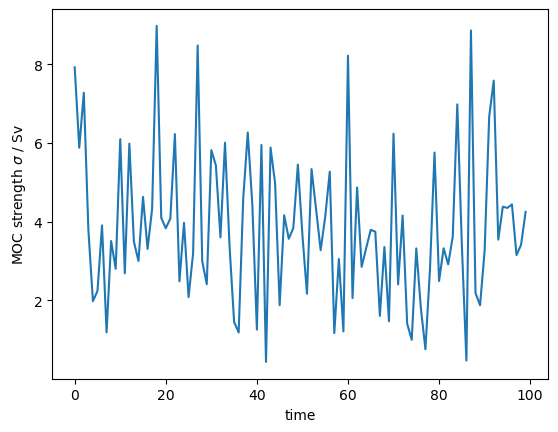

In [26]:
MOC_60S_so.MOC.to_netcdf('processed_data/MOC_60S_so.nc', format="NETCDF4")
MOC_30S_at.MOC.to_netcdf('processed_data/MOC_30S_at.nc', format="NETCDF4")
MOC_30S_pac.MOC.to_netcdf('processed_data/MOC_30S_pac.nc', format="NETCDF4")

Create final input array for modelling

In [ ]:
# select only surface data
input_data_60S_so = access_data_60S_so.sel(st_ocean=0, method='nearest')
input_data_60S_so.to_netcdf('processed_data/input_data_60S_so.nc', format="NETCDF4")

# select only surface data
access_data_30S = access_data.sel(yt_ocean = -30, yu_ocean = -30, method='nearest')
access_data_30S_at = access_data_30S.sel(xt_ocean = slice(-50, 15), xu_ocean = slice(-50, 15))
input_data = access_data_30S_at.sel(st_ocean=0, method='nearest')
input_data.to_netcdf('processed_data/input_data_30S_at.nc', format="NETCDF4")

# select only surface data
access_data_30S = access_data.sel(yt_ocean = -30, yu_ocean = -30, method='nearest')
access_data_30S_pac = access_data_30S.sel(xt_ocean = slice(-205, -70), xu_ocean = slice(-205, -70))
input_data = access_data_30S_pac.sel(st_ocean=0, method='nearest')
input_data.to_netcdf('processed_data/input_data_30S_pac.nc', format="NETCDF4")